# Load in Image

This dataset is a sample from a larger research project. The sample comprises of 16 micrographs. Each micrograph was taken at different temperatures/pressure stored as seperate .jpg files.

## Aims

A program that can :
 
- `Upload`: an image of a micrograph 
- `Crop`: the image to only relevant area
- `Process`: Take scale bar to aid in comparison of images 
- `Process`: Identify indiviual Hydrides in microstructure  

## Import Packages

In [122]:
# We import the packages we need
from matplotlib import pyplot as plt
import re
from PIL import Image
import os, os.path
from os import listdir
import matplotlib.axes
import matplotlib.image as mpimg
import numpy as np
import cv2

# And also we import the functions we have created, which are in the packages folder
from packages import plot_image

## Import the images from github

- Import image [.jpg image] 
- Transpose the image to make the radial direction vertical. 
- Crop scale bar from image and/or crop image to a specific location. 
- Input Scale Bar Value, the scale bar will then be calculated.

In [123]:
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


The data should be placed in a sub-directory called `Micrographs`.

In [124]:
mypath = './Micrographs/'

def_files = sorted_aphanumeric(listdir(mypath))

In [151]:
img = cv2.imread('./Micrographs/chu4.jpg',0)

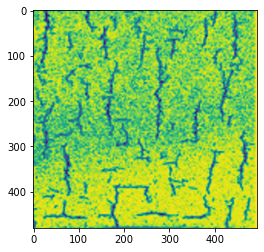

In [152]:
imgplot = plt.imshow(img)

## Image Processing

Produce a monochrome image where the hydrides are white, and the matrix is black. 

Break the images into horizontal strips to reduce the effects of interference on measuring the radial HCC. Blur corresponding strips.

In [155]:
SecNum = 15

while True:
    if (np.size(img,1) % SecNum) !=0:
        SecNum += 1
    else:
        break
        
sections = (np.size(img,1) / SecNum)

tracker = 0

for x in range(0,np.size(img,1),SecNum):
        x1 = x + SecNum
        section = img[0:np.size(img,0), x:x1]
        
        cv2.imwrite("Sections/" + str(tracker) +".jpg",section)
        
        tracker +=1
        
for i in range(0,tracker):
    Sec = cv2.imread("./Sections/" + str(i) + ".jpg",0)
    Blur = cv2.GaussianBlur(Sec, (9,9),0)
    cv2.imwrite("Blurs/" + str(i) +".jpg",Blur)
    
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Blurs/" + str(i-1) + ".jpg")
            ImgR = cv2.imread("./Blurs/" + str(i) + ".jpg")
            BlurJoin = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Blurs/" + str(i) + ".jpg")
            BlurJoin = np.concatenate((BlurJoin, ImgR), axis=1)

cv2.imwrite('BlurJoined.jpg', BlurJoin)


True

## Thresholding

Thresholding - Remove un-wanted features such as X and Y from images.
Side by side comparison to original image and image after thresholding method.
Use 3 different thresholding method and see which one works best .

Otsu method is first carried out

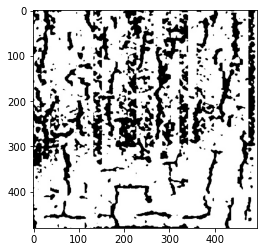

In [156]:
for i in range(tracker):
    Blur = cv2.imread("./Blurs/" + str(i) + ".jpg",0)
    
    ThreshValue, ThreshOtsu = cv2.threshold(Blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cv2.imwrite("Otsu/" + str(i) +".jpg",ThreshOtsu)
    
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Otsu/" + str(i-1) + ".jpg")
            ImgR = cv2.imread("./Otsu/" + str(i) + ".jpg")
            OtsuThresh = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Otsu/" + str(i) + ".jpg")
            OtsuThresh = np.concatenate((OtsuThresh, ImgR), axis=1)

cv2.imwrite('OtsuThresh.jpg', OtsuThresh)

plt.imshow(mpimg.imread('OtsuThresh.jpg'))

Next k-means is attempted

In [143]:
reshapedImage = np.float32(Blur.reshape(-1, 3))

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)

k = 2

ret, labels, clusters = cv2.kmeans(reshapedImage, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

clusters = np.uint8(clusters)

intermediateImage = clusters[labels.flatten()]
clusteredImage = intermediateImage.reshape((img.shape))

cv2.imwrite("KImage.jpg", clusteredImage)

plt.imshow(clusteredImage, 'gray')

ValueError: cannot reshape array of size 7410 into shape (480,494)

## Connecivity of Microstructure 

Asses interconnectivity between hydrides in the radial direction

494

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
